#**Proyecto Análisis de Video**

Integrantes: Matías Bozo y Jorge Morales

Se instalan las bibliotecas necesarias para trabajar con videos y modelos en PyTorch. Además, se utiliza `IPython.display` para limpiar la salida de la celda, eliminando mensajes innecesarios generados durante las instalaciones, y así mantener el notebook más organizado.

In [1]:
!pip install pytorchvideo   # Biblioteca para tareas de video con PyTorch
!pip install torchsummary   # Bibiloteca para resumir arquitecturas
!pip install kaggle         # Biblioteca para interactuar con la API de Kaggle

from IPython import display
display.clear_output()

Se utiliza la funcionalidad de Google Colab para subir archivos desde el sistema local al entorno de trabajo. Esto es necesario para subir el archivo kaggle.json, que contiene las credenciales de la API de Kaggle, permitiendo descargar datasets directamente desde Kaggle.

In [2]:
from google.colab import files

# Se sube el archivo kaggle.json desde el sistema local al entorno de Colab
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"matasbozopizarro","key":"ecd5b25ccfa3da91e256871c16d8c92a"}'}

Se configuran las credenciales de la API de Kaggle. Se crea el directorio necesario para almacenar el archivo kaggle.json, se mueve el archivo a ese directorio y se ajustan los permisos para garantizar la seguridad

In [3]:
# Crear un directorio para Kaggle
!mkdir -p ~/.kaggle

# Mover el archivo kaggle.json subido al directorio de Kaggle
!cp kaggle.json ~/.kaggle/

# Cambiar los permisos del archivo para mayor seguridad
!chmod 600 ~/.kaggle/kaggle.json

Se descarga el dataset desde Kaggle utilizando la API de Kaggle. El parámetro `-d` indica el dataset a descargar, en este caso, "real-life-violence-situations-dataset".


In [4]:
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset

Dataset URL: https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset
License(s): copyright-authors
100% 3.57G/3.58G [00:36<00:00, 69.5MB/s]
100% 3.58G/3.58G [00:36<00:00, 106MB/s] 


In [ ]:
import zipfile

import os

# Specify the path to the zip file
zip_file_path = '/content/real-life-violence-situations-dataset.zip'

# Specify the extraction path
extraction_path = '/content/real-life-violence-situations-dataset/'

# Create a directory to extract the contents
os.makedirs(extraction_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Optional: List the files in the extraction directory
extracted_files = os.listdir(extraction_path)

print("Extracted files:", extracted_files)

Extracted files: ['Real Life Violence Dataset', 'real life violence situations']


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#-- Imports ------------------------------------------------------------------------------------------------------

import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
# from torchsummary import summary
import cv2
# import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import copy


In [ ]:
ds_input_path = '/content/real-life-violence-situations-dataset/Real Life Violence Dataset'

ds_preprocessed_path = '/content/processed-dataset/'

train_path = os.path.join(ds_preprocessed_path, 'train')
val_path = os.path.join(ds_preprocessed_path, 'val')
test_path = os.path.join(ds_preprocessed_path, 'test')

NUM_FRAMES = 16
FRAME_W = 256
FRAME_H = 256

CLASS_NAMES = ['Violence', 'NonViolence']


In [ ]:
os.makedirs(train_path, exist_ok=True)

os.makedirs(val_path, exist_ok=True)

os.makedirs(test_path, exist_ok=True)

In [ ]:
i = 0

for root, dirs, files in os.walk(ds_input_path):
    for filename in files:
        file_path = os.path.join(root, filename)
        if file_path.endswith(('.mp4')):
            cap = cv2.VideoCapture(file_path)
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            print(f"Video: {filename} | number of frames: {num_frames} - Resolution: {width} x {height}")

            # Release the video capture object
            cap.release()
            i += 1

            if i>=10:
                break

Video: NV_547.mp4 | number of frames: 125 - Resolution: 224 x 224
Video: NV_458.mp4 | number of frames: 145 - Resolution: 224 x 224
Video: NV_300.mp4 | number of frames: 159 - Resolution: 640 x 360
Video: NV_494.mp4 | number of frames: 115 - Resolution: 224 x 224
Video: NV_311.mp4 | number of frames: 150 - Resolution: 640 x 360
Video: NV_774.mp4 | number of frames: 115 - Resolution: 224 x 224
Video: NV_505.mp4 | number of frames: 115 - Resolution: 224 x 224
Video: NV_230.mp4 | number of frames: 125 - Resolution: 224 x 224
Video: NV_459.mp4 | number of frames: 145 - Resolution: 224 x 224
Video: NV_677.mp4 | number of frames: 120 - Resolution: 224 x 224
Video: V_915.mp4 | number of frames: 141 - Resolution: 198 x 360


In [ ]:
#-- Function to Preprocess videos -------------------------------------------------------------------------------

def preprocess_video(video_path, output_path, num_frames=NUM_FRAMES, resize=(FRAME_W, FRAME_H)):



    cap = cv2.VideoCapture(video_path)

    frames = []

    while cap.isOpened():

        ret, frame = cap.read()

        if not ret:

            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        frame = cv2.resize(frame, resize)

        frames.append(frame)

    cap.release()



    frames = np.array(frames)



    #-- Sample frames --

    if len(frames) > num_frames:

        indices = np.linspace(0, len(frames) - 1, num_frames).astype(int)

        sampled_frames = frames[indices]

    elif len(frames) < num_frames:

        padding = np.zeros((num_frames - len(frames), *resize, 3))

        sampled_frames = np.concatenate((frames, padding), axis=0)

    else:

        sampled_frames = frames



    #-- Save preprocessed frames --

    np.save(output_path, sampled_frames)

#-------------------------------------------------------------------------------------------------------------

In [ ]:
#-- Preprocees and Split Data ------------------------------------------------------------------------------------

def split_and_preprocess_videos(input_folder, train_dir, val_dir, test_dir, frame_size):



    #-- Create output directories if they don't exist --

    for dir in [train_dir, val_dir, test_dir]:

        os.makedirs(dir, exist_ok=True)



    for class_name in CLASS_NAMES:

        class_folder = os.path.join(input_folder, class_name)



        #-- Get all video files in the class folder --

        videos = [f for f in os.listdir(class_folder) if f.endswith(('.mp4', '.avi', '.mov'))]



        #-- Split into train, val, test --

        train_videos, temp_videos = train_test_split(videos, test_size=0.2, random_state=42)

        val_videos, test_videos = train_test_split(temp_videos, test_size=0.5, random_state=42)



        splits = {'train': train_videos, 'val': val_videos, 'test': test_videos}



        for split in splits:

            split_folder = os.path.join(train_dir if split == 'train' else val_dir if split == 'val' else test_dir, class_name)

            os.makedirs(split_folder, exist_ok=True)



            for video in splits[split]:

                video_path = os.path.join(class_folder, video)

                output_path = os.path.join(split_folder, video.replace('.mp4', '.npy'))

                preprocess_video(video_path, output_path, NUM_FRAMES, frame_size)

                print(f'Processed and saved {video} to {split_folder}')

#-------------------------------------------------------------------------------------------------------------

In [ ]:
#-- Run the preprocessing and splitting ----

split_and_preprocess_videos(input_folder= ds_input_path,

                            train_dir= train_path,

                            val_dir= val_path,

                            test_dir= test_path,

                            frame_size = (FRAME_W, FRAME_H))

#-------------------------------------------------------------------------------------------------------------

Processed and saved V_518.mp4 to /content/processed-dataset/train/Violence
Processed and saved V_676.mp4 to /content/processed-dataset/train/Violence
Processed and saved V_611.mp4 to /content/processed-dataset/train/Violence
Processed and saved V_704.mp4 to /content/processed-dataset/train/Violence
Processed and saved V_740.mp4 to /content/processed-dataset/train/Violence
Processed and saved V_395.mp4 to /content/processed-dataset/train/Violence
Processed and saved V_854.mp4 to /content/processed-dataset/train/Violence
Processed and saved V_450.mp4 to /content/processed-dataset/train/Violence
Processed and saved V_23.mp4 to /content/processed-dataset/train/Violence
Processed and saved V_744.mp4 to /content/processed-dataset/train/Violence
Processed and saved V_667.mp4 to /content/processed-dataset/train/Violence
Processed and saved V_488.mp4 to /content/processed-dataset/train/Violence
Processed and saved V_530.mp4 to /content/processed-dataset/train/Violence
Processed and saved V_195.

In [ ]:
import shutil

# Cambiar la ruta para Google Colab
ds_zip_file = '/content/data'  # Ruta nueva en Colab

# Crear un archivo ZIP a partir del directorio procesado
shutil.make_archive(ds_zip_file, 'zip', ds_preprocessed_path)

# Eliminar el directorio de datos procesados después de comprimirlo
#shutil.rmtree(ds_preprocessed_path)

print(f"Archivo comprimido creado en: {ds_zip_file}.zip")


Archivo comprimido creado en: /content/data.zip


In [ ]:
import torch



import torch.nn as nn

import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data import Dataset, DataLoader



import torchvision

import torchvision.transforms as transforms



from torchsummary import summary



import cv2

import matplotlib.pyplot as plt



import numpy as np

import random



import os

import shutil

import copy

In [ ]:
# Configuración del dispositivo (CPU o GPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {DEVICE}')

# Ruta al archivo ZIP (asegúrate de que el archivo esté en esta ubicación o súbelo manualmente)
ds_zip_path = '/content/fight-detection-x3d-preprocess/data.zip'

# Ruta para descomprimir el archivo
ds_unzip_path = '/content/processed-dataset'  # Cambia "working/ds/" por una ruta válida en Colab

# Parámetros de procesamiento
BATCH_SIZE = 8
NUM_EPOCHS = 2
NUM_FRAMES = 16
FRAME_W = 256
FRAME_H = 256


device: cuda


In [ ]:
def count_samples(data_dir):

    counts = {}



    for subset in ['train', 'val', 'test']:

        subset_path = os.path.join(data_dir, subset)

        counts[subset] = {}



        for category in ['Violence', 'NonViolence']:

            category_path = os.path.join(subset_path, category)

            num_samples = len(os.listdir(category_path))

            counts[subset][category] = num_samples



    return counts

In [ ]:
sample_counts = count_samples(ds_unzip_path)

# Print the sample counts

for subset, categories in sample_counts.items():
    print(f"{subset} set:")
    for category, count in categories.items():
        print(f"  {category}: {count} samples")

train set:
  Violence: 800 samples
  NonViolence: 800 samples
val set:
  Violence: 100 samples
  NonViolence: 100 samples
test set:
  Violence: 100 samples
  NonViolence: 100 samples


In [ ]:
class VideoDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir

        self.transform = transform

        self.classes = ['Violence', 'NonViolence']

        self.frame_paths = []

        self.labels = []



        for label, class_name in enumerate(self.classes):

            class_dir = os.path.join(root_dir, class_name)

            for frame_file in os.listdir(class_dir):

                frame_path = os.path.join(class_dir, frame_file)

                self.frame_paths.append(frame_path)

                self.labels.append(label)



    def __len__(self):

        return len(self.frame_paths)



    def __getitem__(self, idx):

        frame_path = self.frame_paths[idx]

        label = self.labels[idx]



        frames = np.load(frame_path)



        if self.transform:

            frames = self.transform(frames)



        return frames, label

In [ ]:
class ToTensor(object):

    def __call__(self, sample):

        frames = sample



        #-- Convert to Tensor (C, T, H, W) --

        frames = frames.transpose((3, 0, 1, 2))

        frames = torch.from_numpy(frames).float()



        #-- Normalize --

        frames = frames / 255.0

        return frames

In [ ]:
import os

# Construye correctamente las rutas para train, val y test
train_dir = os.path.join(ds_unzip_path, 'train')
val_dir = os.path.join(ds_unzip_path, 'val')
test_dir = os.path.join(ds_unzip_path, 'test')



#-- Data transformations --

data_transforms = {

    'train': transforms.Compose([ToTensor()]),

    'val': transforms.Compose([ToTensor()]),

    'test': transforms.Compose([ToTensor()]),

}



#-- Create datasets for train, val, and test --

train_dataset = VideoDataset(root_dir=train_dir, transform=data_transforms['train'])

val_dataset = VideoDataset(root_dir=val_dir, transform=data_transforms['val'])

test_dataset = VideoDataset(root_dir=test_dir, transform=data_transforms['test'])



#-- Create DataLoaders --

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
#-- Check Data Loaders -------------------------------------------------------------------------------------------

for i, (videos, labels) in enumerate(train_loader):

        print(videos.shape, labels.shape)

        break

torch.Size([8, 3, 16, 256, 256]) torch.Size([8])


In [ ]:
#-- Function to Modify X3D for finetuning ------------------------------------------------------------------------

def custome_X3D(num_classes):

    #-- load X3D model --

    model_name = 'x3d_m'

    model = torch.hub.load('facebookresearch/pytorchvideo', model_name, pretrained=True)



    #-- set last layer for custome classification --

    input_size = model.blocks[-1].proj.in_features

    model.blocks[-1].proj = nn.Linear(in_features=input_size, out_features=num_classes)



    return model

In [ ]:


def train(model, loader, optimizer, criterion):

    model.train()



    running_loss = 0.0

    correct = 0

    total = 0



    for videos, labels in loader:



        videos, labels = videos.to(DEVICE), labels.to(DEVICE)



        optimizer.zero_grad()

        outputs = model(videos)





        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()



        running_loss += loss.item()

        _, predicted = outputs.max(1)

        total += labels.size(0)

        correct += predicted.eq(labels).sum().item()

        loss = running_loss / len(loader)

    accuracy = correct / total

    return loss , accuracy



In [ ]:
def evaluate(model, loader, criterion):

    model.eval()



    correct = 0

    total = 0

    running_loss = 0.0



    with torch.no_grad():

        for inputs, labels in loader:

            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)

            loss = criterion(outputs, labels)



            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)

            correct += (predicted == labels).sum().item()



    loss = running_loss / len(loader)

    acc = correct / total

    return loss , acc

In [ ]:
num_classes = 2  # For Fighting and Normal

model = custome_X3D(num_classes).to(DEVICE)





optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/X3D_M.pyth" to /root/.cache/torch/hub/checkpoints/X3D_M.pyth
100%|██████████| 29.4M/29.4M [00:00<00:00, 45.3MB/s]


In [ ]:
summary(model, input_size=(3,16,256,256), device=DEVICE.type, batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 24, 16, 128, 128]             648
            Conv3d-2     [-1, 24, 16, 128, 128]             120
       Conv2plus1d-3     [-1, 24, 16, 128, 128]               0
       BatchNorm3d-4     [-1, 24, 16, 128, 128]              48
              ReLU-5     [-1, 24, 16, 128, 128]               0
   ResNetBasicStem-6     [-1, 24, 16, 128, 128]               0
            Conv3d-7       [-1, 24, 16, 64, 64]             576
            Conv3d-8     [-1, 54, 16, 128, 128]           1,296
       BatchNorm3d-9     [-1, 54, 16, 128, 128]             108
             ReLU-10     [-1, 54, 16, 128, 128]               0
           Conv3d-11       [-1, 54, 16, 64, 64]           1,458
      BatchNorm3d-12       [-1, 54, 16, 64, 64]             108
           Conv3d-13           [-1, 8, 1, 1, 1]             440
             ReLU-14           [-1, 8, 

In [ ]:
import torch
import copy

# Assuming the model is already defined, and you have two GPUs available (T4 x2).
# Check if multiple GPUs are available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If there are multiple GPUs, use DataParallel to wrap the model
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)  # Wrap the model in DataParallel
    model = model.to(device)
else:
    model = model.to(device)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_model = None
best_acc = 0

# Training loop
for epoch in range(NUM_EPOCHS):

    # Train the model on the training dataset
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    # Evaluate the model on the validation dataset
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    # Save the losses and accuracies for analysis
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # If validation accuracy is the best, update best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = copy.deepcopy(model)

    # Print training and validation progress
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, '
          f'Train Loss: {train_loss:.4f}, Train ACC: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val ACC: {val_acc:.4f}')

# Save the final trained model
last_model = copy.deepcopy(model)

Epoch 1/2, Train Loss: 0.2780, Train ACC: 0.9000, Val Loss: 0.1156, Val ACC: 0.9700
Epoch 2/2, Train Loss: 0.1417, Train ACC: 0.9525, Val Loss: 0.1832, Val ACC: 0.9250


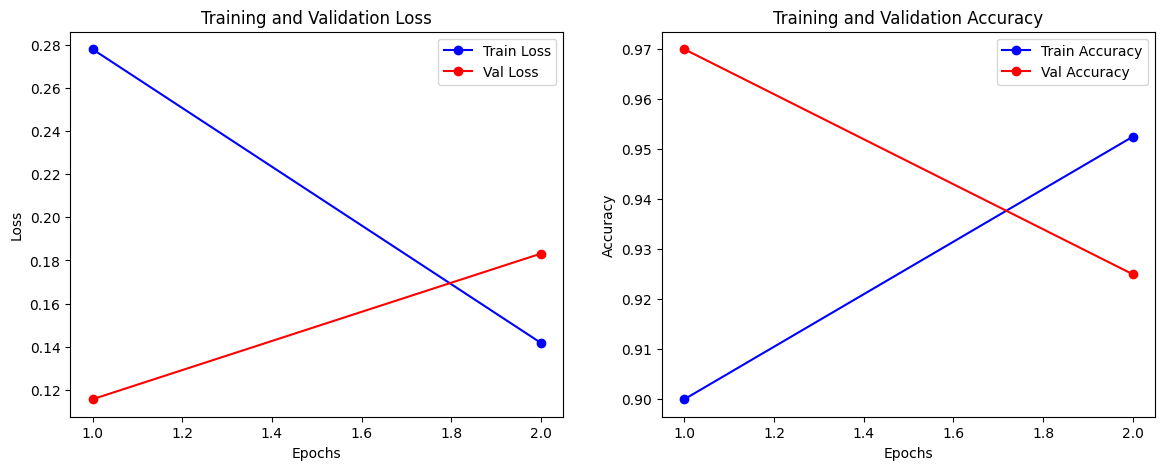

In [ ]:
epochs = range(1, NUM_EPOCHS + 1)



plt.figure(figsize=(14, 5))



# Plot training & validation loss

plt.subplot(1, 2, 1)

plt.plot(epochs, train_losses, 'bo-', label='Train Loss')

plt.plot(epochs, val_losses, 'ro-', label='Val Loss')

plt.title('Training and Validation Loss')

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend()



# Plot training & validation accuracy

plt.subplot(1, 2, 2)

plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')

plt.plot(epochs, val_accuracies, 'ro-', label='Val Accuracy')

plt.title('Training and Validation Accuracy')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.legend()



plt.show()

In [ ]:
import torch

# Guardar el modelo con PyTorch en Colab
torch.save(best_model.state_dict(), '/content/best_model.pth')
torch.save(last_model.state_dict(), '/content/last_model.pth')


In [ ]:
test_loss, test_acc = evaluate(best_model, test_loader, criterion)

print(f'Final Test Accuracy: {test_acc:.4f}')

Final Test Accuracy: 0.9700


In [ ]:
train_loss, train_acc = evaluate(last_model, train_loader, criterion)

val_loss, val_acc = evaluate(last_model, val_loader, criterion)

test_loss, test_acc = evaluate(last_model, test_loader, criterion)



print('Last Weights:\n'

         f'Train Loss: {train_loss: .4f} - Train ACC: {train_acc: .4f}\n'

         f'Val Loss: {val_loss: .4f} - Val ACC: {val_acc: .4f}\n'

         f'Test Loss: {test_loss: .4f} - Test ACC: {test_acc: .4f}')



#-- best model --

train_loss, train_acc = evaluate(best_model, train_loader, criterion)

val_loss, val_acc = evaluate(best_model, val_loader, criterion)

test_loss, test_acc = evaluate(best_model, test_loader, criterion)



print('\n\nBest Weights:\n'

         f'Train Loss: {train_loss: .4f} - Train ACC: {train_acc: .4f}\n'

         f'Val Loss: {val_loss: .4f} - Val ACC: {val_acc: .4f}\n'

         f'Test Loss: {test_loss: .4f} - Test ACC: {test_acc: .4f}')

Last Weights:
Train Loss:  0.0543 - Train ACC:  0.9819
Val Loss:  0.1832 - Val ACC:  0.9250
Test Loss:  0.0861 - Test ACC:  0.9600


Best Weights:
Train Loss:  0.0714 - Train ACC:  0.9769
Val Loss:  0.1156 - Val ACC:  0.9700
Test Loss:  0.0787 - Test ACC:  0.9700


In [ ]:
# prompt: haz una matriz de confusión

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ... (your existing code) ...

# Assuming 'best_model' is your trained model and 'test_loader' is your test data loader

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

NameError: name 'torch' is not defined